In [3]:
import pandas as pd
import numpy as np

# Data Preprocessing

In [4]:
df = pd.read_csv('Auction_master/Auction_master_train.csv')

In [5]:
df.head()

Auction_key Auction_class Bid_class  Claim_price Appraisal_company  \
0         2687            임의        개별   1766037301              정명감정   
1         2577            임의        일반    152946867               희감정   
2         2197            임의        개별     11326510              혜림감정   
3         2642            임의        일반    183581724              신라감정   
4         1958            강제        일반     45887671              나라감정   

        Appraisal_date  Auction_count  Auction_miscarriage_count  \
0  2017-07-26 00:00:00              2                          1   
1  2016-09-12 00:00:00              2                          1   
2  2016-11-22 00:00:00              3                          2   
3  2016-12-13 00:00:00              2                          1   
4  2016-03-07 00:00:00              2                          1   

   Total_land_gross_area  Total_land_real_area     ...       Specific  \
0                12592.0                 37.35     ...            NaN   
1                42478.1                 18.76     ...            NaN   
2               149683.1                 71.00     ...            NaN   
3                24405.0                 32.98     ...            NaN   
4                  774.0                 45.18     ...            NaN   

   Share_auction_YorN   road_name  road_bunji1  road_bunji2  \
0                   N      해운대해변로         30.0          NaN   
1                   N      마린시티2로         33.0          NaN   
2                   N    모라로110번길         88.0          NaN   
3                   N  황령대로319번가길        110.0          NaN   
4                   N         오작로         51.0          NaN   

            Close_date Close_result    point.y     point.x Hammer_price  
0  2018-06-14 00:00:00           배당  35.162717  129.137048    760000000  
1  2017-03-30 00:00:00           배당  35.156633  129.145068    971889999  
2  2017-12-13 00:00:00           배당  35.184601  128.996765     93399999  
3  2017-12-27 00:00:00           배당  35.154180  129.089081    256899000  
4  2016-10-04 00:00:00           배당  35.099630  128.998874    158660000  

[5 rows x 41 columns]

## Set label (Hammer price 상위 50% 와 하위 50%)

In [6]:
#Hammer price 중앙값
med = df['Hammer_price'].median()
med

354450000.0

In [7]:
#Median 보다 크면 1, 작다면 0 설정
df.loc[df['Hammer_price'] >= med, 'label'] = 1
df.loc[df['Hammer_price'] < med, 'label'] = 0
df[['Hammer_price','label']].head(10)

Hammer_price  label
0     760000000    1.0
1     971889999    1.0
2      93399999    0.0
3     256899000    0.0
4     158660000    0.0
5     206989000    0.0
6     135500000    0.0
7     640299999    1.0
8      77380000    0.0
9     177070000    0.0

## Linear Regression 과 유사한 방식으로 전처리하였습니다.
- (날짜를 제외하고) 범주형 변수 중 unique 값이 10개 이상인 변수 제거 
- 예측에 의미 없는 final_result, auciton_key 제거
- 주소에 대한 정보는 부산/서울, 위도로 충분하다고 가정
- 날짜변수는 율리안 날짜로 변환

In [8]:
#범주형 변수 선택
categorical_col = list(df.select_dtypes(include='object').columns)

In [9]:
#Unique 값이 10 개 이상인 범주형 변수 선택
categorical_col = [i for i in categorical_col if len(set(df[i])) >= 10 and 'date' not in i]
categorical_col

['Appraisal_company',
 'Creditor',
 'addr_si',
 'addr_dong',
 'addr_li',
 'addr_etc',
 'Specific',
 'road_name']

In [10]:
#선택된 변수 제거 
df = df.drop(labels = categorical_col, axis = 1)
df.columns

Index(['Auction_key', 'Auction_class', 'Bid_class', 'Claim_price',
       'Appraisal_date', 'Auction_count', 'Auction_miscarriage_count',
       'Total_land_gross_area', 'Total_land_real_area',
       'Total_land_auction_area', 'Total_building_area',
       'Total_building_auction_area', 'Total_appraisal_price',
       'Minimum_sales_price', 'First_auction_date', 'Final_auction_date',
       'Final_result', 'addr_do', 'addr_san', 'addr_bunji1', 'addr_bunji2',
       'Apartment_usage', 'Preserve_regist_date', 'Total_floor',
       'Current_floor', 'Share_auction_YorN', 'road_bunji1', 'road_bunji2',
       'Close_date', 'Close_result', 'point.y', 'point.x', 'Hammer_price',
       'label'],
      dtype='object')

In [11]:
#예측에 의미 없는 변수 및 추가적인 주소에 관한 변수 제거
del df['Final_result']
del df['Auction_key']

#'addr_do' 를 제외하고 주소 정보 columns 선택
add_var = [i for i in list(df.columns) if 'addr' in i and i != 'addr_do']
road_var = [i for i in list(df.columns) if 'road' in i ]

df = df.drop(labels = add_var + road_var, axis =1 )

### 나머지 범주형 변수 label encoding
**모두 nominal value 이지만 attribute 이 3개 이하라 label encoding 했습니다

In [12]:
categorical_col = list(df.select_dtypes(include='object').columns)
categorical_col = [i for i in categorical_col if 'date' not in i]
categorical_col

['Auction_class',
 'Bid_class',
 'addr_do',
 'Apartment_usage',
 'Share_auction_YorN',
 'Close_result']

In [13]:
#카테고리형 변수로 변환
for cat in categorical_col:
    df[cat] = df[cat].astype('category')
    df[cat] = df[cat].cat.codes

In [14]:
#예시
df['Auction_class'].head(5)

0    1
1    1
2    1
3    1
4    0
Name: Auction_class, dtype: int8

### 날짜 변수 처리

In [15]:
#Julian Date 로 변환하는 함수
import math

def date_to_jd(date):

    year = int(date[:4])
    month = int(date[5:7])
    day = int(date[8:10])
    if month == 1 or month == 2:
        yearp = year - 1
        monthp = month + 12
    else:
        yearp = year
        monthp = month
    
    # this checks where we are in relation to October 15, 1582, the beginning
    # of the Gregorian calendar.
    if ((year < 1582) or
        (year == 1582 and month < 10) or
        (year == 1582 and month == 10 and day < 15)):
        # before start of Gregorian calendar
        B = 0
    else:
        # after start of Gregorian calendar
        A = math.trunc(yearp / 100.)
        B = 2 - A + math.trunc(A / 4.)
        
    if yearp < 0:
        C = math.trunc((365.25 * yearp) - 0.75)
    else:
        C = math.trunc(365.25 * yearp)
        
    D = math.trunc(30.6001 * (monthp + 1))
    
    jd = B + C + D + day + 1720994.5
    
    return jd

In [16]:
date_var = [i for i in list(df.columns) if 'date' in i]
date_var

['Appraisal_date',
 'First_auction_date',
 'Final_auction_date',
 'Preserve_regist_date',
 'Close_date']

In [17]:
for date in date_var:
    df[date] = df[date].apply(date_to_jd)

In [18]:
sel_features = df.columns
sel_features

Index(['Auction_class', 'Bid_class', 'Claim_price', 'Appraisal_date',
       'Auction_count', 'Auction_miscarriage_count', 'Total_land_gross_area',
       'Total_land_real_area', 'Total_land_auction_area',
       'Total_building_area', 'Total_building_auction_area',
       'Total_appraisal_price', 'Minimum_sales_price', 'First_auction_date',
       'Final_auction_date', 'addr_do', 'Apartment_usage',
       'Preserve_regist_date', 'Total_floor', 'Current_floor',
       'Share_auction_YorN', 'Close_date', 'Close_result', 'point.y',
       'point.x', 'Hammer_price', 'label'],
      dtype='object')

# SVM model

In [19]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [20]:
X = df.drop(['Hammer_price','label'],axis=1)
y = df['label']

In [21]:
#Using linear SVC
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('liear_svc', LinearSVC(C=1, loss='hinge', random_state=42))
])

svm_clf.fit(X, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('liear_svc', LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=42, tol=0.0001, verbose=0))])

In [22]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
#Reference: 박규리님 참고자료
def fivefold(X,y,model):
    model_scores = np.zeros(5)
    scores = np.zeros(5)
    if type(X) is np.ndarray:
        X = pd.DataFrame(X)


    cv = KFold(5, shuffle=False, random_state=0)
    for i, (idx_train, idx_test) in enumerate(cv.split(X)):
        #데이터 하나씩 트레인과 테스트에 부과
        X_train = X.iloc[idx_train]
        X_test = X.iloc[idx_test]
        y_train, y_test = y[idx_train], y[idx_test]

        #모델 fit
        result = model.fit(X_train,y_train)

        #prediction
        model_pred = result.predict(X_train)
        pred = result.predict(X_test)
        model_acc = accuracy_score(y_train, model_pred)
        acc = accuracy_score(y_test, pred)

        #test 5번 하나하나 프린트
        model_scores[i] = model_acc
        scores[i] = acc
        print("학습 accuacy = {:.2f}, 검증 accuacy = {:.2f}".format(model_acc, acc))
    print('평균 train accuacy : %.2f'  %(model_scores.mean()))
    print('평균 test accuacy : %.2f'  %(scores.mean()))

In [23]:
import warnings
warnings.filterwarnings('ignore') #hide warnings

fivefold(X,y,svm_clf)

학습 accuacy = 0.97, 검증 accuacy = 0.97
학습 accuacy = 0.97, 검증 accuacy = 0.97
학습 accuacy = 0.97, 검증 accuacy = 0.95
학습 accuacy = 0.97, 검증 accuacy = 0.96
학습 accuacy = 0.97, 검증 accuacy = 0.96
평균 train accuacy : 0.97
평균 test accuacy : 0.96


## PCA 적용 

In [24]:
from sklearn.decomposition import PCA

In [25]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca)

In [26]:
pca.explained_variance_ratio_
#Ratio of variance explained
#PC1 : 70.9%, PC2: 28.6%
#Total: 99.5%

array([0.70852506, 0.28616402])

In [27]:
fivefold(X_pca,y,svm_clf)
#성능에서 큰 차이 없음

학습 accuacy = 0.97, 검증 accuacy = 0.98
학습 accuacy = 0.97, 검증 accuacy = 0.97
학습 accuacy = 0.98, 검증 accuacy = 0.95
학습 accuacy = 0.97, 검증 accuacy = 0.97
학습 accuacy = 0.97, 검증 accuacy = 0.97
평균 train accuacy : 0.97
평균 test accuacy : 0.97


### 실험 : 쓸모없는 feature 가 있는가?

In [28]:
X.columns

Index(['Auction_class', 'Bid_class', 'Claim_price', 'Appraisal_date',
       'Auction_count', 'Auction_miscarriage_count', 'Total_land_gross_area',
       'Total_land_real_area', 'Total_land_auction_area',
       'Total_building_area', 'Total_building_auction_area',
       'Total_appraisal_price', 'Minimum_sales_price', 'First_auction_date',
       'Final_auction_date', 'addr_do', 'Apartment_usage',
       'Preserve_regist_date', 'Total_floor', 'Current_floor',
       'Share_auction_YorN', 'Close_date', 'Close_result', 'point.y',
       'point.x'],
      dtype='object')

In [29]:
#날짜 변수 제거
trial_var1 = [i for i in list(X.columns) if 'date' in i]
trial_var1

['Appraisal_date',
 'First_auction_date',
 'Final_auction_date',
 'Preserve_regist_date',
 'Close_date']

In [30]:
X_trial1 = X.drop(trial_var1, axis=1)

In [31]:
fivefold(X_trial1,y,svm_clf)

학습 accuacy = 0.97, 검증 accuacy = 0.98
학습 accuacy = 0.97, 검증 accuacy = 0.97
학습 accuacy = 0.97, 검증 accuacy = 0.95
학습 accuacy = 0.97, 검증 accuacy = 0.95
학습 accuacy = 0.97, 검증 accuacy = 0.96
평균 train accuacy : 0.97
평균 test accuacy : 0.96


In [32]:
#범주형 변수 제거 
trial_var2 = [i for i in list(categorical_col)]
trial_var2

['Auction_class',
 'Bid_class',
 'addr_do',
 'Apartment_usage',
 'Share_auction_YorN',
 'Close_result']

In [33]:
X_trial2 = X.drop(trial_var2, axis=1)

In [34]:
fivefold(X_trial2,y,svm_clf)

학습 accuacy = 0.96, 검증 accuacy = 0.97
학습 accuacy = 0.97, 검증 accuacy = 0.97
학습 accuacy = 0.97, 검증 accuacy = 0.95
학습 accuacy = 0.97, 검증 accuacy = 0.96
학습 accuacy = 0.97, 검증 accuacy = 0.96
평균 train accuacy : 0.97
평균 test accuacy : 0.96


In [35]:
#토지 크기에 대한 변수 제거

In [36]:
trial_var4 = [i for i in list(X.columns) if 'area' in i]
trial_var4

['Total_land_gross_area',
 'Total_land_real_area',
 'Total_land_auction_area',
 'Total_building_area',
 'Total_building_auction_area']

In [37]:
X_trial4 = X.drop(trial_var4,axis =1)
fivefold(X_trial4,y,svm_clf)

학습 accuacy = 0.97, 검증 accuacy = 0.97
학습 accuacy = 0.97, 검증 accuacy = 0.97
학습 accuacy = 0.97, 검증 accuacy = 0.95
학습 accuacy = 0.97, 검증 accuacy = 0.97
학습 accuacy = 0.97, 검증 accuacy = 0.97
평균 train accuacy : 0.97
평균 test accuacy : 0.97


In [38]:
#가격에 대한 변수 제거

In [39]:
trial_var3 = [i for i in list(X.columns) if 'price' in i]
trial_var3

['Claim_price', 'Total_appraisal_price', 'Minimum_sales_price']

In [40]:
X_trial3 = X.drop(trial_var3, axis =1)

In [41]:
fivefold(X_trial3,y,svm_clf)

학습 accuacy = 0.87, 검증 accuacy = 0.93
학습 accuacy = 0.88, 검증 accuacy = 0.90
학습 accuacy = 0.89, 검증 accuacy = 0.85
학습 accuacy = 0.89, 검증 accuacy = 0.86
학습 accuacy = 0.90, 검증 accuacy = 0.85
평균 train accuacy : 0.89
평균 test accuacy : 0.88


In [42]:
#토지/가격 모두 제거
X_last = X.drop(trial_var3 +trial_var4, axis =1)

In [43]:
fivefold(X_last,y,svm_clf)

학습 accuacy = 0.75, 검증 accuacy = 0.85
학습 accuacy = 0.74, 검증 accuacy = 0.84
학습 accuacy = 0.79, 검증 accuacy = 0.67
학습 accuacy = 0.78, 검증 accuacy = 0.73
학습 accuacy = 0.78, 검증 accuacy = 0.72
평균 train accuacy : 0.77
평균 test accuacy : 0.76


#### Point 1
- 날짜/볌주형/토지 크기 관련 변수를 제거했을때는 성능에 아무런 영향이 없었지만 예상했던 대로 가격에 관한 변수를 제거했을때 모델 성능이 크게 떨어졌습니다. 


#### Point 2
- 이는 Linear Regression 을 에서 보았듯이 최저매각가격 (Minimum_sales_price) , 총감정가 (Total_appraisal_price) 가 경매가에 가장 큰 영향을 주는 것을 알 수 있습니다.


#### Point 3
- 흥미롭게도 토지 크기량과 가격에 대한 변수를 모두 제거 했을때 가격만 제거했을때보다 성능이 급격히 감소했습니다. 이를 통해서 토지-가격 변수가 상호작용하는 무언가가 있음을 알 수 있습니다.

## Fine-tuning : Grid Search

In [44]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

In [45]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_pca)

In [46]:
from __future__ import print_function
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from datetime import datetime


In [47]:
#Hyperparameter Initialization
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']
clf_type = SVC()

In [48]:
#function for gridsearch
def grid_search(X,y,clf_type = clf_type,scores=['precision','recall'],tuned_parameters=tuned_parameters):
    start_time = datetime.now()

    #Reference : Sci-kit documentation
    #위 레퍼런스와 stackoverflow를 참고했습니다.

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(clf_type, tuned_parameters, cv=5, n_jobs=4,
                           scoring='%s_macro' % score)
        clf.fit(X, y)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y, clf.predict(X)
        print(classification_report(y_true, y_pred))
        print()

    end_time = datetime.now()
    print('\n\n\nDuration:{}'.format(end_time-start_time))

In [49]:
grid_search(X_scaled,y)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1000, 'kernel': 'linear'}

Grid scores on development set:

0.250 (+/-0.001) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.250 (+/-0.001) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.250 (+/-0.001) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.250 (+/-0.001) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.509 (+/-0.431) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.250 (+/-0.001) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.789 (+/-0.014) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.509 (+/-0.431) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.761 (+/-0.009) for {'C': 1, 'kernel': 'linear'}
0.871 (+/-0.033) for {'C': 10, 'kernel': 'linear'}
0.959 (+/-0.037) for {'C': 100, 'kernel': 'linear'}
0.963 (+/-0.017) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full 

#### 결론:
 - 실험환경: 
     Kernel: 'linear', 'rbf'
     C: '1-1000'
     gamma: '0.0001 - 0.001'
 - Precision 과 recall 에서 모두 {'C': 1000, 'kernel': 'linear'} 의 성능이 가장 우수했습니다.

# KNN

In [50]:
from sklearn.neighbors import KNeighborsClassifier  

In [51]:
knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_scaled,y)
knn_y_pred = knn_clf.predict(X_scaled)

In [52]:
print(classification_report(y,knn_y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       966
         1.0       0.97      0.98      0.97       967

   micro avg       0.97      0.97      0.97      1933
   macro avg       0.97      0.97      0.97      1933
weighted avg       0.97      0.97      0.97      1933



### Visualization

In [53]:
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
import matplotlib
%matplotlib inline

In [54]:
h=0.001

x_min = X_scaled[:,0].min() - 0.5
x_max = X_scaled[:,0].max() + 0.5
y_min = X_scaled[:,1].min() - 0.5
y_max = X_scaled[:,1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = knn_clf.predict(np.c_[xx.ravel(), yy.ravel()])

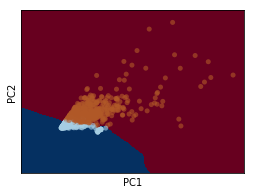

<Figure size 2160x1080 with 0 Axes>

In [55]:

Z = Z.reshape(xx.shape)
pl.figure(1, figsize=(4, 3))
pl.set_cmap(pl.cm.Paired)
pl.pcolormesh(xx, yy, Z,cmap='RdBu_r')
matplotlib.rcParams['lines.markersize'] = 5
pl.scatter(X_scaled[:,0], X_scaled[:,1],c=y,marker="o",edgecolors='none',alpha=0.6 )
pl.xlabel('PC1')
pl.ylabel('PC2')

pl.xlim(X_scaled[:,0].min()-0.05, 0.23) #데이터가 집중적으로 모인 지점으로 포커스
pl.ylim(X_scaled[:,1].min()+0.1, 0.4)
pl.xticks(())
pl.yticks(())
pl.figure(figsize=(30,15))
pl.show()

## Fine-tuning: Grid Search

In [56]:
tuned_parameters = {'n_neighbors': [1,3,5,7,9]}
grid_search(X_scaled,y,knn_clf,tuned_parameters=tuned_parameters)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_neighbors': 5}

Grid scores on development set:

0.953 (+/-0.026) for {'n_neighbors': 1}
0.962 (+/-0.016) for {'n_neighbors': 3}
0.962 (+/-0.025) for {'n_neighbors': 5}
0.961 (+/-0.021) for {'n_neighbors': 7}
0.961 (+/-0.025) for {'n_neighbors': 9}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       966
         1.0       0.97      0.98      0.97       967

   micro avg       0.97      0.97      0.97      1933
   macro avg       0.97      0.97      0.97      1933
weighted avg       0.97      0.97      0.97      1933


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'n_neighbors': 3}

Grid scores on development set:

0.951 (+/-0.030) for {'n_neighbors': 1}
0.960 (+/-0.018)

#### 결론:
 - Precision 이 가장 우수한 것은 n = 5
 - Recall 이 가장 우수한 것은 n = 3
 - 끝점이(n = 9) 아님을 확인했으므로 그리드서치를 종료한다. 

# Naive Bayes

## Feature Selection :
 - Mutual info regression 을 통해 변수간 독립성을 확인
 - Mutual info 는 양수값을 가지며 독립일때 0을 가짐
 - Reference : https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_regression.html

In [57]:
from sklearn.feature_selection import mutual_info_regression

In [58]:
X.columns

Index(['Auction_class', 'Bid_class', 'Claim_price', 'Appraisal_date',
       'Auction_count', 'Auction_miscarriage_count', 'Total_land_gross_area',
       'Total_land_real_area', 'Total_land_auction_area',
       'Total_building_area', 'Total_building_auction_area',
       'Total_appraisal_price', 'Minimum_sales_price', 'First_auction_date',
       'Final_auction_date', 'addr_do', 'Apartment_usage',
       'Preserve_regist_date', 'Total_floor', 'Current_floor',
       'Share_auction_YorN', 'Close_date', 'Close_result', 'point.y',
       'point.x'],
      dtype='object')

In [62]:
#turn off warnings
import warnings
warnings.filterwarnings('ignore')


x1 = X['Total_land_auction_area'].values.reshape(-1,1)
x2 = X['Total_land_real_area'].values.reshape(-1,1)
print(mutual_info_regression(x1,x2))

[5.79409178]


In [63]:
x1 = X['Total_building_auction_area'].values.reshape(-1,1)
x2 = X['Total_building_area'].values.reshape(-1,1)
print(mutual_info_regression(x1,x2))

[5.55141937]


In [64]:
x1 = X['Total_appraisal_price'].values.reshape(-1,1)
x2 = X['Minimum_sales_price'].values.reshape(-1,1)
print(mutual_info_regression(x1,x2))

[0.43227327]


#### 모든 변수들간의 Mutual info (MI) 을 반환하는 함수:
 - 상관계수가 높은 (0.98) 'Total_appraisal_price' 와 'Minimum_sales_price' 의 MI 를 threshold 로 설정해 변수를 삭제했습니다.

In [65]:
def check_dependence(columns, threshold):
    output = []
    for idx,col1 in enumerate(columns):
        x1 = X[col1].values.reshape(-1,1)
        for col2 in columns[idx+1:]:
            x2 = X[col2].values.reshape(-1,1)
            info = float(mutual_info_regression(x1,x2))
            if info > threshold:
                output.append([col1,col2,info])
    return output

In [66]:
warnings.filterwarnings('ignore')

output = check_dependence(list(X.columns),0.4)
output

[['Appraisal_date', 'First_auction_date', 1.3785470507311075],
 ['Appraisal_date', 'Final_auction_date', 1.0182258417462147],
 ['Appraisal_date', 'Close_date', 0.9596571900235391],
 ['Auction_count', 'Auction_miscarriage_count', 0.8727769112419308],
 ['Total_land_gross_area', 'Total_land_real_area', 0.48507985135577236],
 ['Total_land_gross_area', 'Total_land_auction_area', 0.45368358026876177],
 ['Total_land_gross_area', 'Preserve_regist_date', 0.8698276437079304],
 ['Total_land_gross_area', 'Total_floor', 0.532205816363418],
 ['Total_land_gross_area', 'point.y', 0.8478602986706427],
 ['Total_land_gross_area', 'point.x', 0.8256500458078286],
 ['Total_land_real_area', 'Total_land_auction_area', 5.795998418006219],
 ['Total_land_real_area', 'Total_building_area', 0.678320694668348],
 ['Total_land_real_area', 'Total_building_auction_area', 0.6226462188894706],
 ['Total_land_auction_area', 'Total_building_area', 0.6297090488434209],
 ['Total_land_auction_area',
  'Total_building_auction_a

In [67]:
del_list = [i[0] for i in output]
del_list

['Appraisal_date',
 'Appraisal_date',
 'Appraisal_date',
 'Auction_count',
 'Total_land_gross_area',
 'Total_land_gross_area',
 'Total_land_gross_area',
 'Total_land_gross_area',
 'Total_land_gross_area',
 'Total_land_gross_area',
 'Total_land_real_area',
 'Total_land_real_area',
 'Total_land_real_area',
 'Total_land_auction_area',
 'Total_land_auction_area',
 'Total_building_area',
 'Total_building_area',
 'Total_building_area',
 'Total_building_area',
 'Total_building_auction_area',
 'Total_building_auction_area',
 'Total_building_auction_area',
 'Total_appraisal_price',
 'First_auction_date',
 'First_auction_date',
 'Final_auction_date',
 'addr_do',
 'addr_do',
 'Preserve_regist_date',
 'Preserve_regist_date',
 'Preserve_regist_date',
 'point.y']

In [68]:
X_independent = X.drop(del_list,axis = 1)
X_independent.columns

Index(['Auction_class', 'Bid_class', 'Claim_price',
       'Auction_miscarriage_count', 'Minimum_sales_price', 'Apartment_usage',
       'Total_floor', 'Current_floor', 'Share_auction_YorN', 'Close_date',
       'Close_result', 'point.x'],
      dtype='object')

In [69]:
X_independent = scaler.fit_transform(X_independent)

In [70]:
X_nb = scaler.fit_transform(X)

## Model

In [71]:
from sklearn.naive_bayes import GaussianNB

In [72]:
nb_clf = GaussianNB()
nb_clf.fit(X_nb, y)
y_pred = nb_clf.predict(X_nb)

#### 초기 모델 : 모든 데이터 사용

In [73]:
print('Accuracy of initial model without preprocessing: %.3f' %accuracy_score(y,y_pred))

Accuracy of initial model without preprocessing: 0.859


#### MI 값을 통해 독립성이 확인되지 않은 변수 제거

In [74]:
nb_clf.fit(X_independent,y)
print('Accuracy of model with preprocessing: %.3f' %accuracy_score(y,nb_clf.predict(X_independent)))

Accuracy of model with preprocessing: 0.919


#### PCA 를 통해 차원축소된 변수

In [75]:
nb_clf.fit(X_scaled,y)
print('Accuracy of model with sacled X_pca: %.3f' %accuracy_score(y,nb_clf.predict(X_scaled)))

Accuracy of model with sacled X_pca: 0.667


### Fine-tuning: 양분점을 조정

In [76]:
def find_optimal_threshold(columns, threshold):
    output = []
    for idx,col1 in enumerate(columns):
        x1 = X[col1].values.reshape(-1,1)
        for col2 in columns[idx+1:]:
            x2 = X[col2].values.reshape(-1,1)
            info = float(mutual_info_regression(x1,x2))
            if info > threshold:
                output.append([col1,col2,info])
    del_list = [i[0] for i in output]
    X_independent = X.drop(del_list,axis = 1)
    X_independent = scaler.fit_transform(X_independent)
    nb_clf = GaussianNB()
    nb_clf.fit(X_independent, y)
    y_pred = nb_clf.predict(X_independent)
    print('Accuracy for threshold {}: {} '.format(threshold,accuracy_score(y,y_pred)))
    return None

In [77]:
#0-5 구간에서 확인; step = 0.5
temp_list = np.arange(0,5,0.5)

In [78]:
for thr in temp_list:
    find_optimal_threshold(list(X.columns), thr)

Accuracy for threshold 0.0: 0.7201241593378168 
Accuracy for threshold 0.5: 0.9244697361614072 
Accuracy for threshold 1.0: 0.8851526125193999 
Accuracy for threshold 1.5: 0.8882565959648215 
Accuracy for threshold 2.0: 0.8903259182617693 
Accuracy for threshold 2.5: 0.8903259182617693 
Accuracy for threshold 3.0: 0.8913605794102432 
Accuracy for threshold 3.5: 0.8913605794102432 
Accuracy for threshold 4.0: 0.8913605794102432 
Accuracy for threshold 4.5: 0.8913605794102432 


In [79]:
#0-2 구간에서 확인; step = 0.1
temp_list = np.arange(0.2,1,0.1)
for thr in temp_list:
    find_optimal_threshold(list(X.columns), thr)

Accuracy for threshold 0.2: 0.752715985514744 
Accuracy for threshold 0.30000000000000004: 0.9161924469736161 
Accuracy for threshold 0.4000000000000001: 0.9187790998448008 
Accuracy for threshold 0.5000000000000001: 0.9244697361614072 
Accuracy for threshold 0.6000000000000001: 0.9063631660631143 
Accuracy for threshold 0.7000000000000002: 0.9141231246766683 
Accuracy for threshold 0.8000000000000003: 0.892912571132954 
Accuracy for threshold 0.9000000000000001: 0.8851526125193999 


### Five-fold validation

In [76]:
fivefold(X_independent,y,nb_clf)

학습 accuacy = 0.90, 검증 accuacy = 0.90
학습 accuacy = 0.91, 검증 accuacy = 0.94
학습 accuacy = 0.90, 검증 accuacy = 0.87
학습 accuacy = 0.92, 검증 accuacy = 0.92
학습 accuacy = 0.92, 검증 accuacy = 0.92
평균 train accuacy : 0.91
평균 test accuacy : 0.91


# Logistic Regression

In [81]:
from sklearn.linear_model import LogisticRegression

In [82]:
clf_lr = LogisticRegression()
clf_lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### 초기 모델 : 모든 데이터 사용

In [83]:
y_pred = clf_lr.predict(X)
accuracy_score(y,y_pred)

0.966890843248836

#### Scaled 데이터 사용

In [84]:
from sklearn.preprocessing import StandardScaler

In [85]:
scaler = StandardScaler()

In [86]:
y_pred = clf_lr.predict(scaler.fit_transform(X))
accuracy_score(y,y_pred)

0.5090532850491464

#### PCA 데이터

In [83]:
clf_lr.fit(X_pca, y)
y_pred = clf_lr.predict(X_pca)
accuracy_score(y,y_pred)

0.8070356958096223

#### PCA-scaled 데이터 

In [84]:
clf_lr.fit(X_scaled, y)
y_pred = clf_lr.predict(X_scaled)
accuracy_score(y,y_pred)

0.8028970512157269

#### (Approximately) independent 데이터 사용

In [85]:
clf_lr.fit(X_independent, y)
y_pred = clf_lr.predict(X_independent)
accuracy_score(y,y_pred)

0.7837558199689602

### Five-fold validation

In [86]:
fivefold(X,y,clf_lr)

학습 accuacy = 0.96, 검증 accuacy = 0.98
학습 accuacy = 0.97, 검증 accuacy = 0.96
학습 accuacy = 0.97, 검증 accuacy = 0.95
학습 accuacy = 0.97, 검증 accuacy = 0.97
학습 accuacy = 0.97, 검증 accuacy = 0.97
평균 train accuacy : 0.97
평균 test accuacy : 0.97


# 결론:
 - 성능은 SVM, KNN, Logistic Regression 모두 유사하고 Navie Baysian Model (NB) 이 뒤를 따른다. 
 - SVM 과 KNN 은 추가적인 전처리 없이 PCA 처리된 데이터로도 최고 성능을 보였지만 Logistic Regression 와 NB 는 PCA 데이터로는 성능이 저하됐습니다. 

# 실험 : 
 - 파생변수로 SVM 모델이 예측하는 label 을 추가하면 Linear Regression 성능이 나아지는가?

In [91]:
svm_clf.fit(X_pca,y)
y_pred = svm_clf.predict(X_pca)

In [93]:
label = pd.DataFrame(data=y_pred, columns=['label'])

In [103]:
X_exp = pd.concat([X,label], axis = 1)

In [96]:
y = df['Hammer_price']

### Initial Model

In [97]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X,y)
model.score(X,y)

0.990827010326752

In [98]:
from sklearn.model_selection import cross_validate as CV

#Ten-fold validation , score metric = negative mean squared error 
score = CV(model,X, y, cv=10, scoring='neg_mean_squared_error')

In [99]:
rmse = (score['test_score'] * -1) **(1/2)

In [100]:
rmse.mean()

67024844.62140924

### 파생변수 추가 

In [107]:
#파생변수 추가
model = LinearRegression().fit(X_exp,y)

#Ten-fold validation , score metric = negative mean squared error 
score = CV(model,X_exp, y, cv=10, scoring='neg_mean_squared_error')
rmse = (score['test_score'] * -1) **(1/2)
rmse.mean()

66044788.68581228